## Chokepoints Monitor - Methodology
The Data Lab at the World Bank used IMF PortWatch to study the Red Sea shipping crisis. This event began in October 2023, when missile attacks on ships and tankers traversing the Red Sea caused hundreds of vessels to avoid the Suez Canal. The attacks are concentrated near the Bab al-Mandab Strait, a 20-mile-wide chokepoint for maritime traffic.

The following example is based on the commented study.

### Chokepoints of interest

The first step is to detect the chokepoints of interest. Since the example is based on the Red Sea crisis, it studies the following chokepoints:
- Bab el-Mandeb Strait
- Cape of Good Hope
- Suez Canal

In [8]:
# Use already downloaded chokepoints
cpoi = ["Bab el-Mandeb Strait", "Cape of Good Hope", "Suez Canal"]
chokepoints_rs = chokepoints_gdf[chokepoints_gdf['portname'].isin(cpoi)]
chokepoints_rs

portid              portname country  ISO3 continent  \
0  chokepoint1            Suez Canal    None  None      None   
3  chokepoint4  Bab el-Mandeb Strait    None  None      None   
6  chokepoint7     Cape of Good Hope    None  None      None   

               fullname        lat        lon  vessel_count_total  \
0            Suez Canal  30.593346  32.436882               22217   
3  Bab el-Mandeb Strait  12.788597  43.349545               22519   
6     Cape of Good Hope -34.927286  20.882737               17332   

   vessel_count_container  vessel_count_dry_bulk  vessel_count_general_cargo  \
0                    6455                   5870                        2097   
3                    6280                   5940                        1839   
6                    2018                  10277                         709   

   vessel_count_RoRo  vessel_count_tanker     industry_top1  \
0                876                 6919  Mineral Products   
3               1074                 7386  Mineral Products   
6                355                 3973  Mineral Products   

                  industry_top2                    industry_top3  \
0            Vegetable Products     Chemical & Allied Industries   
3  Chemical & Allied Industries               Vegetable Products   
6            Vegetable Products  Prepared Foodstuffs & Beverages   

  share_country_maritime_import share_country_maritime_export LOCODE  \
0                          None                          None   None   
3                          None                          None   None   
6                          None                          None   None   

                             pageid countrynoaccents  ObjectId  \
0  c57c79bf612b4372b08a9c6ea9c97ef0             None         1   
3  6b1814d64903461b98144a6cc25eb79c             None         4   
6  edf18f455a2b4637a3632b6af201abe9             None         7   

                     geometry  
0   POINT (32.43688 30.59335)  
3    POINT (43.34954 12.7886)  
6  POINT (20.88274 -34.92729)

In [9]:
chokepoints_rs[
    [
        "geometry",
        "portname",
        "vessel_count_total",
        "vessel_count_container",
        "vessel_count_dry_bulk",
        "vessel_count_general_cargo",
        "vessel_count_RoRo",
        "vessel_count_tanker",
        "industry_top1",
        "industry_top2",
        "industry_top3",
    ]
].explore(
    column="portname",
    cmap="Dark2",
    marker_kwds={"radius": 15},
    tiles="Esri Ocean Basemap",
    legend_kwds={"loc": "upper right", "caption": "Choke Points"},
)

### Retrieve the data
The example processes the daily transit calls and estimated volume (capacity) since 2019 for the three chokepoints of interest: Bab el-Mandeb Strait, Cape of Good Hope, Suez Canal.

To build the URL for the API call, first, go to IMF PortWatch site and build a sample URL. The one below was created to retrieve information for chokepoint 1, 4, and 7. This will be useful for creating a function to retrieve the daily calls for the chokepoints of interest.

https://services9.arcgis.com/weJ1QsnbMYJlCHdG/arcgis/rest/services/Daily_Chokepoints_Data/FeatureServer/0/query?where=portid%20%3D%20'CHOKEPOINT1'%20OR%20portid%20%3D%20'CHOKEPOINT4'%20OR%20portid%20%3D%20'CHOKEPOINT7'&outFields=*&outSR=4326&f=json

The function also needs to take into account that IMF PortWatch only returns 1000 records per call.

In [10]:
def get_chokepoint_data(chokepoints, url_base):
    for chokepoint in chokepoints:
        if chokepoint == chokepoints[-1]:
            url_base += f"portid%3D%20'{chokepoint}'%20&outFields=*&outSR=4326&f=json&resultOffset=0"
        else:
            url_base += f"portid%3D%20'{chokepoint}'%20+OR+"
    res = requests.get(url_base)
    df = pd.DataFrame([d["attributes"] for d in res.json()["features"]])
    offset = 1000
    while len(df) % 1000 == 0: #retrieve 1000 records
        res = requests.get(url_base.replace("resultOffset=0", f"resultOffset={offset}"))
        df2 = pd.DataFrame([d["attributes"] for d in res.json()["features"]])
        df = pd.concat([df, df2])
        offset += 1000
    df.reset_index(inplace=True, drop=True)
    df["date"] = df.date.apply(lambda x: datetime.fromtimestamp(x / 1000))
    df.sort_values(["portid", "date"], inplace=True)
    return df

In [11]:
url_base = "https://services9.arcgis.com/weJ1QsnbMYJlCHdG/arcgis/rest/services/Daily_Chokepoints_Data/FeatureServer/0/query?where="
df_chokepoints = get_chokepoint_data(list(chokepoints[chokepoints['portname'].isin(cpoi)].portid.unique()), url_base)
df_chokepoints.loc[:, "ymd"] = df_chokepoints.date.dt.strftime("%Y-%m-%d")

In [12]:
df_chokepoints.head()

date  year  month  day       portid    portname  n_container  \
0 2018-12-31 21:00:00  2019      1    1  chokepoint1  Suez Canal           23   
2 2019-01-01 21:00:00  2019      1    2  chokepoint1  Suez Canal           26   
4 2019-01-02 21:00:00  2019      1    3  chokepoint1  Suez Canal           12   
5 2019-01-03 21:00:00  2019      1    4  chokepoint1  Suez Canal           18   
7 2019-01-04 21:00:00  2019      1    5  chokepoint1  Suez Canal           20   

   n_dry_bulk  n_general_cargo  n_roro  n_tanker  n_cargo  n_total  \
0          22               14       4        22       63       85   
2           4                6       5        10       41       51   
4          16               10       3        24       41       65   
5          13                1       1        15       33       48   
7           9                1       1        13       31       44   

   capacity_container  capacity_dry_bulk  capacity_general_cargo  \
0        1.937886e+06       9.439567e+05           174972.926920   
2        2.647842e+06       2.389135e+05            33158.163236   
4        7.566682e+05       1.050450e+06            81769.437679   
5        1.668678e+06       5.830442e+05             1028.904676   
7        1.982599e+06       7.714141e+05             1542.093497   

   capacity_roro  capacity_tanker  capacity_cargo      capacity  ObjectId  \
0   46461.102534     1.326360e+06    3.103276e+06  4.429637e+06         1   
2   99397.705404     6.181574e+05    3.019311e+06  3.637469e+06         3   
4   50061.205601     1.069216e+06    1.938949e+06  3.008165e+06         5   
5   16193.424839     1.102152e+06    2.268945e+06  3.371097e+06         6   
7   16313.755096     6.854480e+05    2.771869e+06  3.457317e+06         8   

          ymd  
0  2018-12-31  
2  2019-01-01  
4  2019-01-02  
5  2019-01-03  
7  2019-01-04

### Data Smoothening
A 7-day moving average was created to smoothen out the data and mitigate the effect of daily anomalies.

In [13]:
df_chokepoints = df_chokepoints.loc[df_chokepoints.date >= "2019-01-01"].copy()

In [14]:
df_chokepoints = (
    df_chokepoints.groupby("portname")[["n_tanker", "n_cargo", "n_total", "capacity", "date"]]
    .rolling(7, center=True, min_periods=1, on="date")
    .mean()
)
df_chokepoints.reset_index(inplace=True)
df_chokepoints.drop("level_1", axis=1, inplace=True)
df_chokepoints.loc[:, "ymd"] = df_chokepoints.date.dt.strftime("%Y-%m-%d")
df_chokepoints.loc[:, "md"] = df_chokepoints.date.dt.strftime("%m-%d")

In [15]:
df_chokepoints.head()

portname      capacity    n_cargo   n_tanker    n_total  \
0  Bab el-Mandeb Strait  3.888476e+06  42.000000  18.250000  60.250000   
1  Bab el-Mandeb Strait  3.866908e+06  40.600000  18.200000  58.800000   
2  Bab el-Mandeb Strait  3.822667e+06  41.000000  18.166667  59.166667   
3  Bab el-Mandeb Strait  3.693581e+06  40.428571  17.714286  58.142857   
4  Bab el-Mandeb Strait  3.614515e+06  38.857143  17.714286  56.571429   

                 date         ymd     md  
0 2019-01-01 21:00:00  2019-01-01  01-01  
1 2019-01-02 21:00:00  2019-01-02  01-02  
2 2019-01-03 21:00:00  2019-01-03  01-03  
3 2019-01-04 21:00:00  2019-01-04  01-04  
4 2019-01-05 21:00:00  2019-01-05  01-05

### AIS Transit Calls in Key Areas, Historical

This notebook uses [plotnine](https://python-graph-gallery.com/plotnine/), a package that allows to use the grammar of graphics in Python. The library is based on the famous ggplot2 library in R. 

In [16]:
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

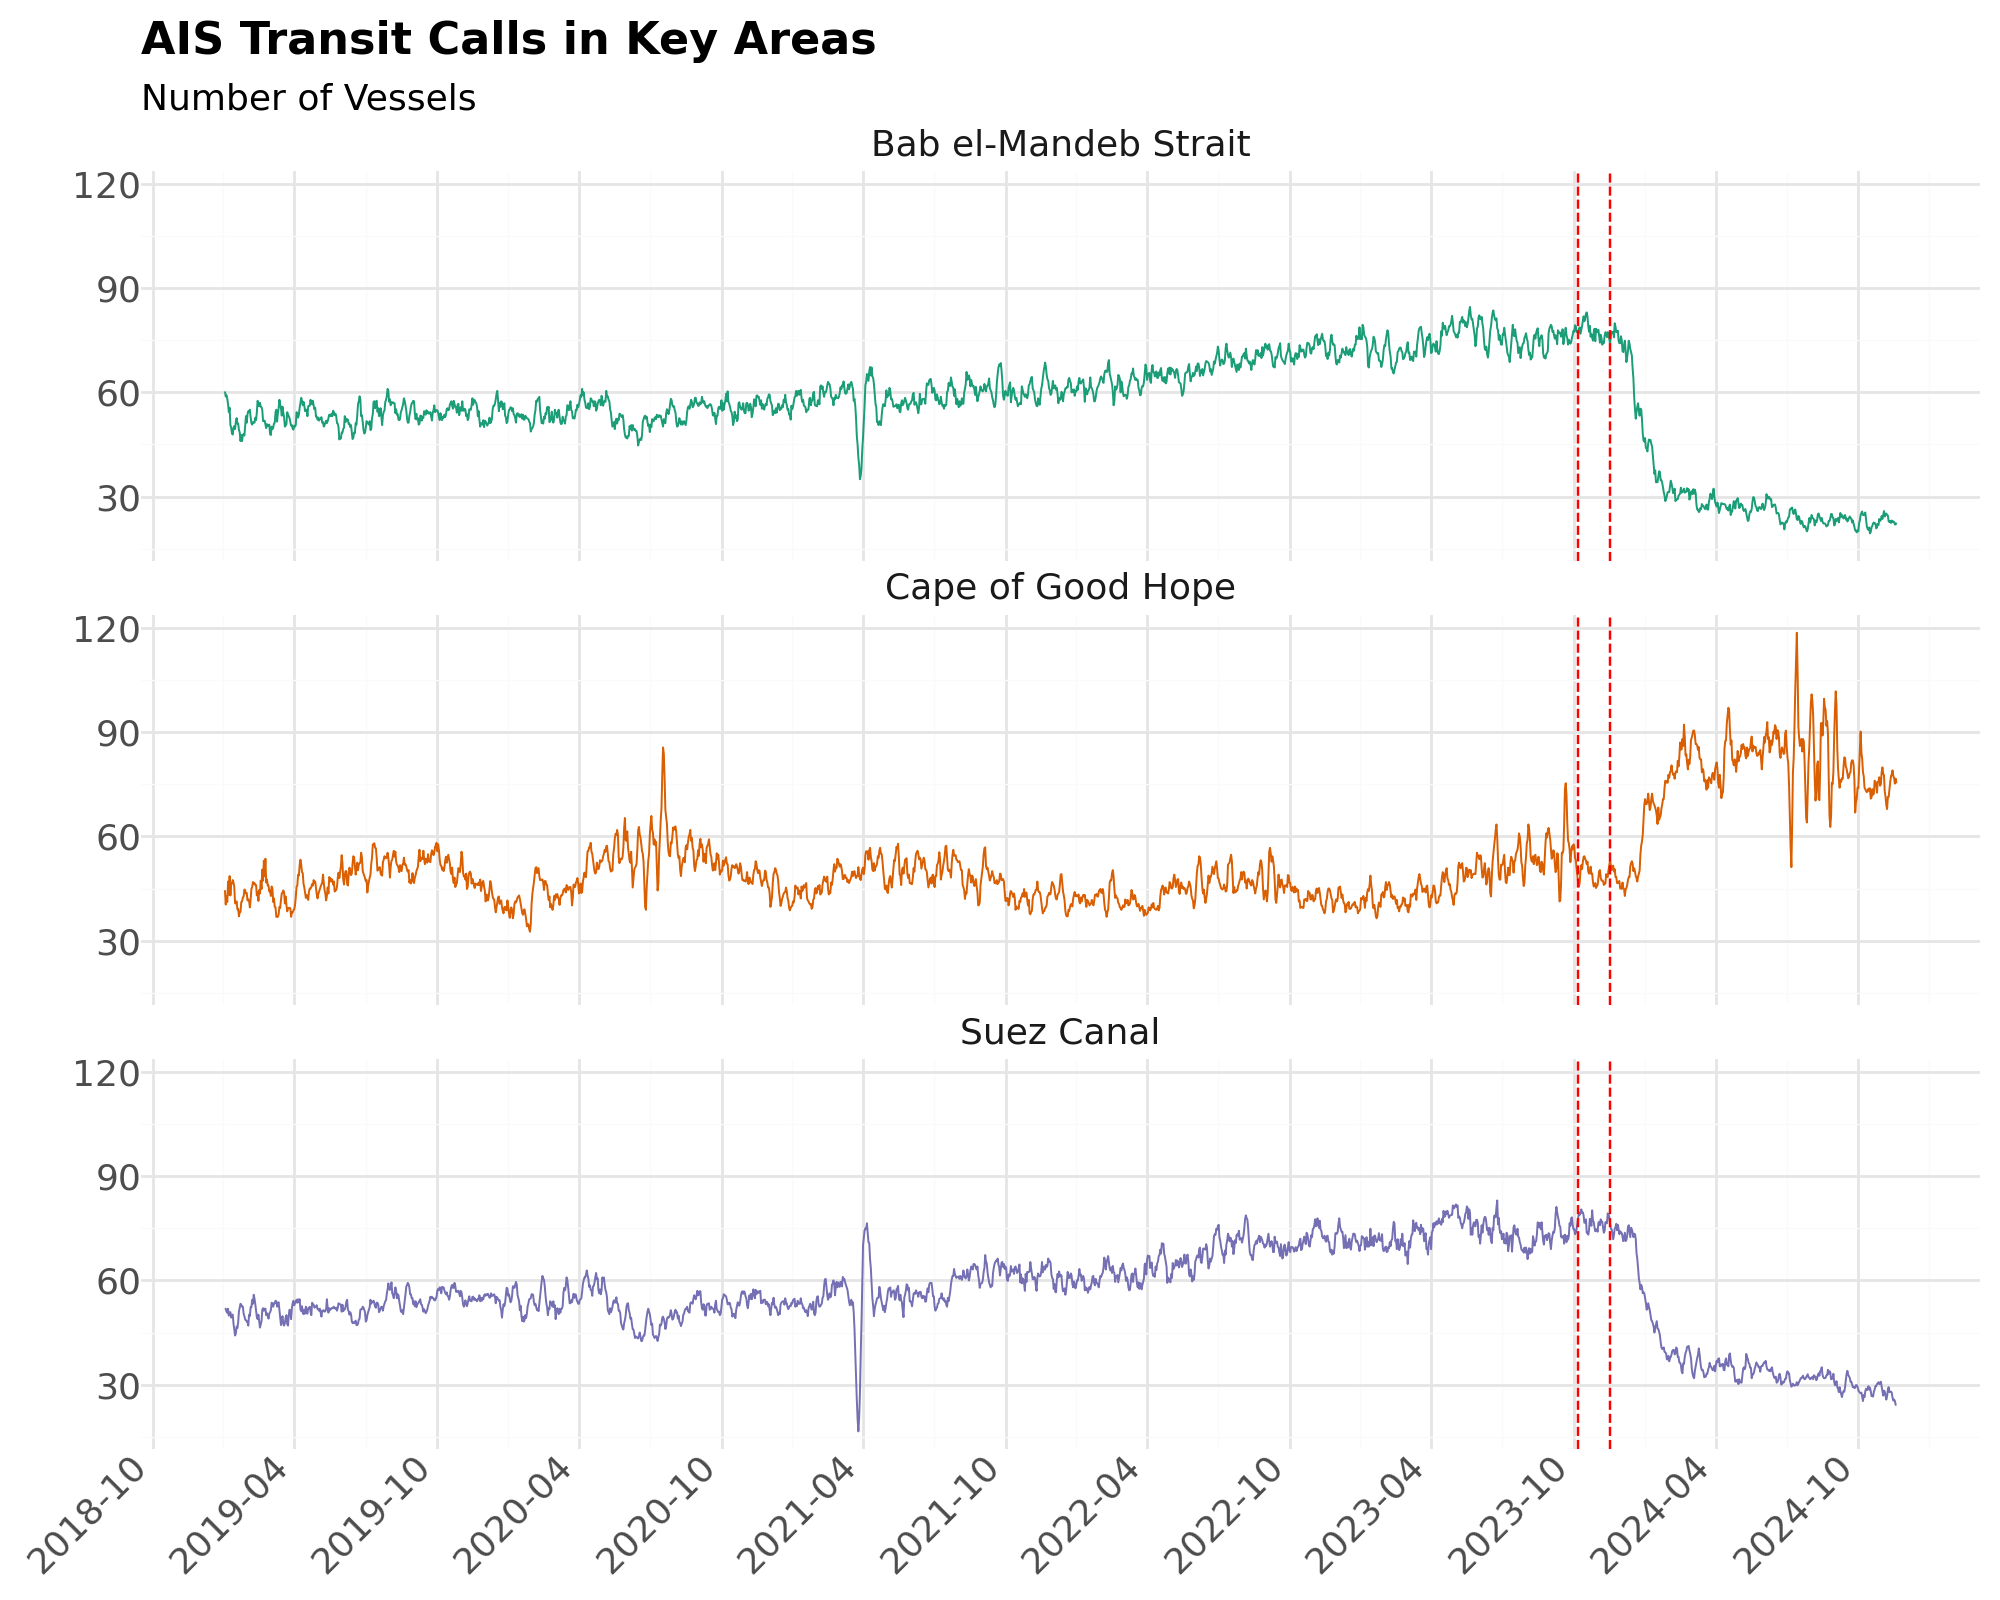

/home/sol/venv/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 10 x 8 in image.
/home/sol/venv/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: transit-calls-chokepoints-historical.jpeg


In [17]:
p0 = (
    ggplot(df_chokepoints, aes(x="date", y="n_total", group="portname", color="portname"))  #
    + geom_line(alpha=1, size=0.4)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + labs(
        x="",
        y="",
        subtitle="Number of Vessels",
        title="AIS Transit Calls in Key Areas",
        color="Area of Interest",
    )
    + theme_minimal()
    + scale_x_datetime(breaks=date_breaks("6 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + theme(
        text=element_text(size=13),
        plot_title=element_text(size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
    + facet_wrap("~portname", scales="fixed", ncol=1)
)
display(p0)
p0.save(
    filename="transit-calls-chokepoints-historical.jpeg",
    dpi=300,
)

### Reference Period
Given the volatility of 2021, the team defined the reference period as January 1st 2022 up to October 6th 2023. Daily averages were calculated based on this time period.

Periods:
- **Baseline**: 2021, 2022, 2023 (January 1st – October 6th)
- **Middle East Conflict**: 2023 (October 7th - November 16th)
- **Red Sea Crisis**: November 17th - January 31st, 2024

In [18]:
start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

Create the reference data by day and month.

In [19]:
df_ref = df_chokepoints.loc[(df_chokepoints.date >= start_reference_date) & (df_chokepoints.date < conflict_date)].copy()
df_ref = df_ref.groupby(["portname", "md"])[
    ["n_tanker", "n_cargo", "n_total", "capacity"]
].mean()
df_ref.reset_index(inplace=True)
df_ref.rename(
    columns={
        "n_tanker": "n_tanker_ref",
        "n_cargo": "n_cargo_ref",
        "n_total": "n_total_ref",
        "capacity": "capacity_ref",
    },
    inplace=True,
)

Filter recent data (2023 onwards) and merge it with the reference values by day and month.

In [20]:
df_filt = df_chokepoints.loc[(df_chokepoints.date >= "2023-01-01")].copy()
df_filt = df_filt.merge(df_ref, on=["portname", "md"], how="left", validate="m:1")

Calculate percentage change.

In [21]:
df_filt.loc[:, "n_total_pct_ch"] = df_filt.apply(
    lambda x: (x.n_total - x.n_total_ref) / (x.n_total_ref), axis=1
)

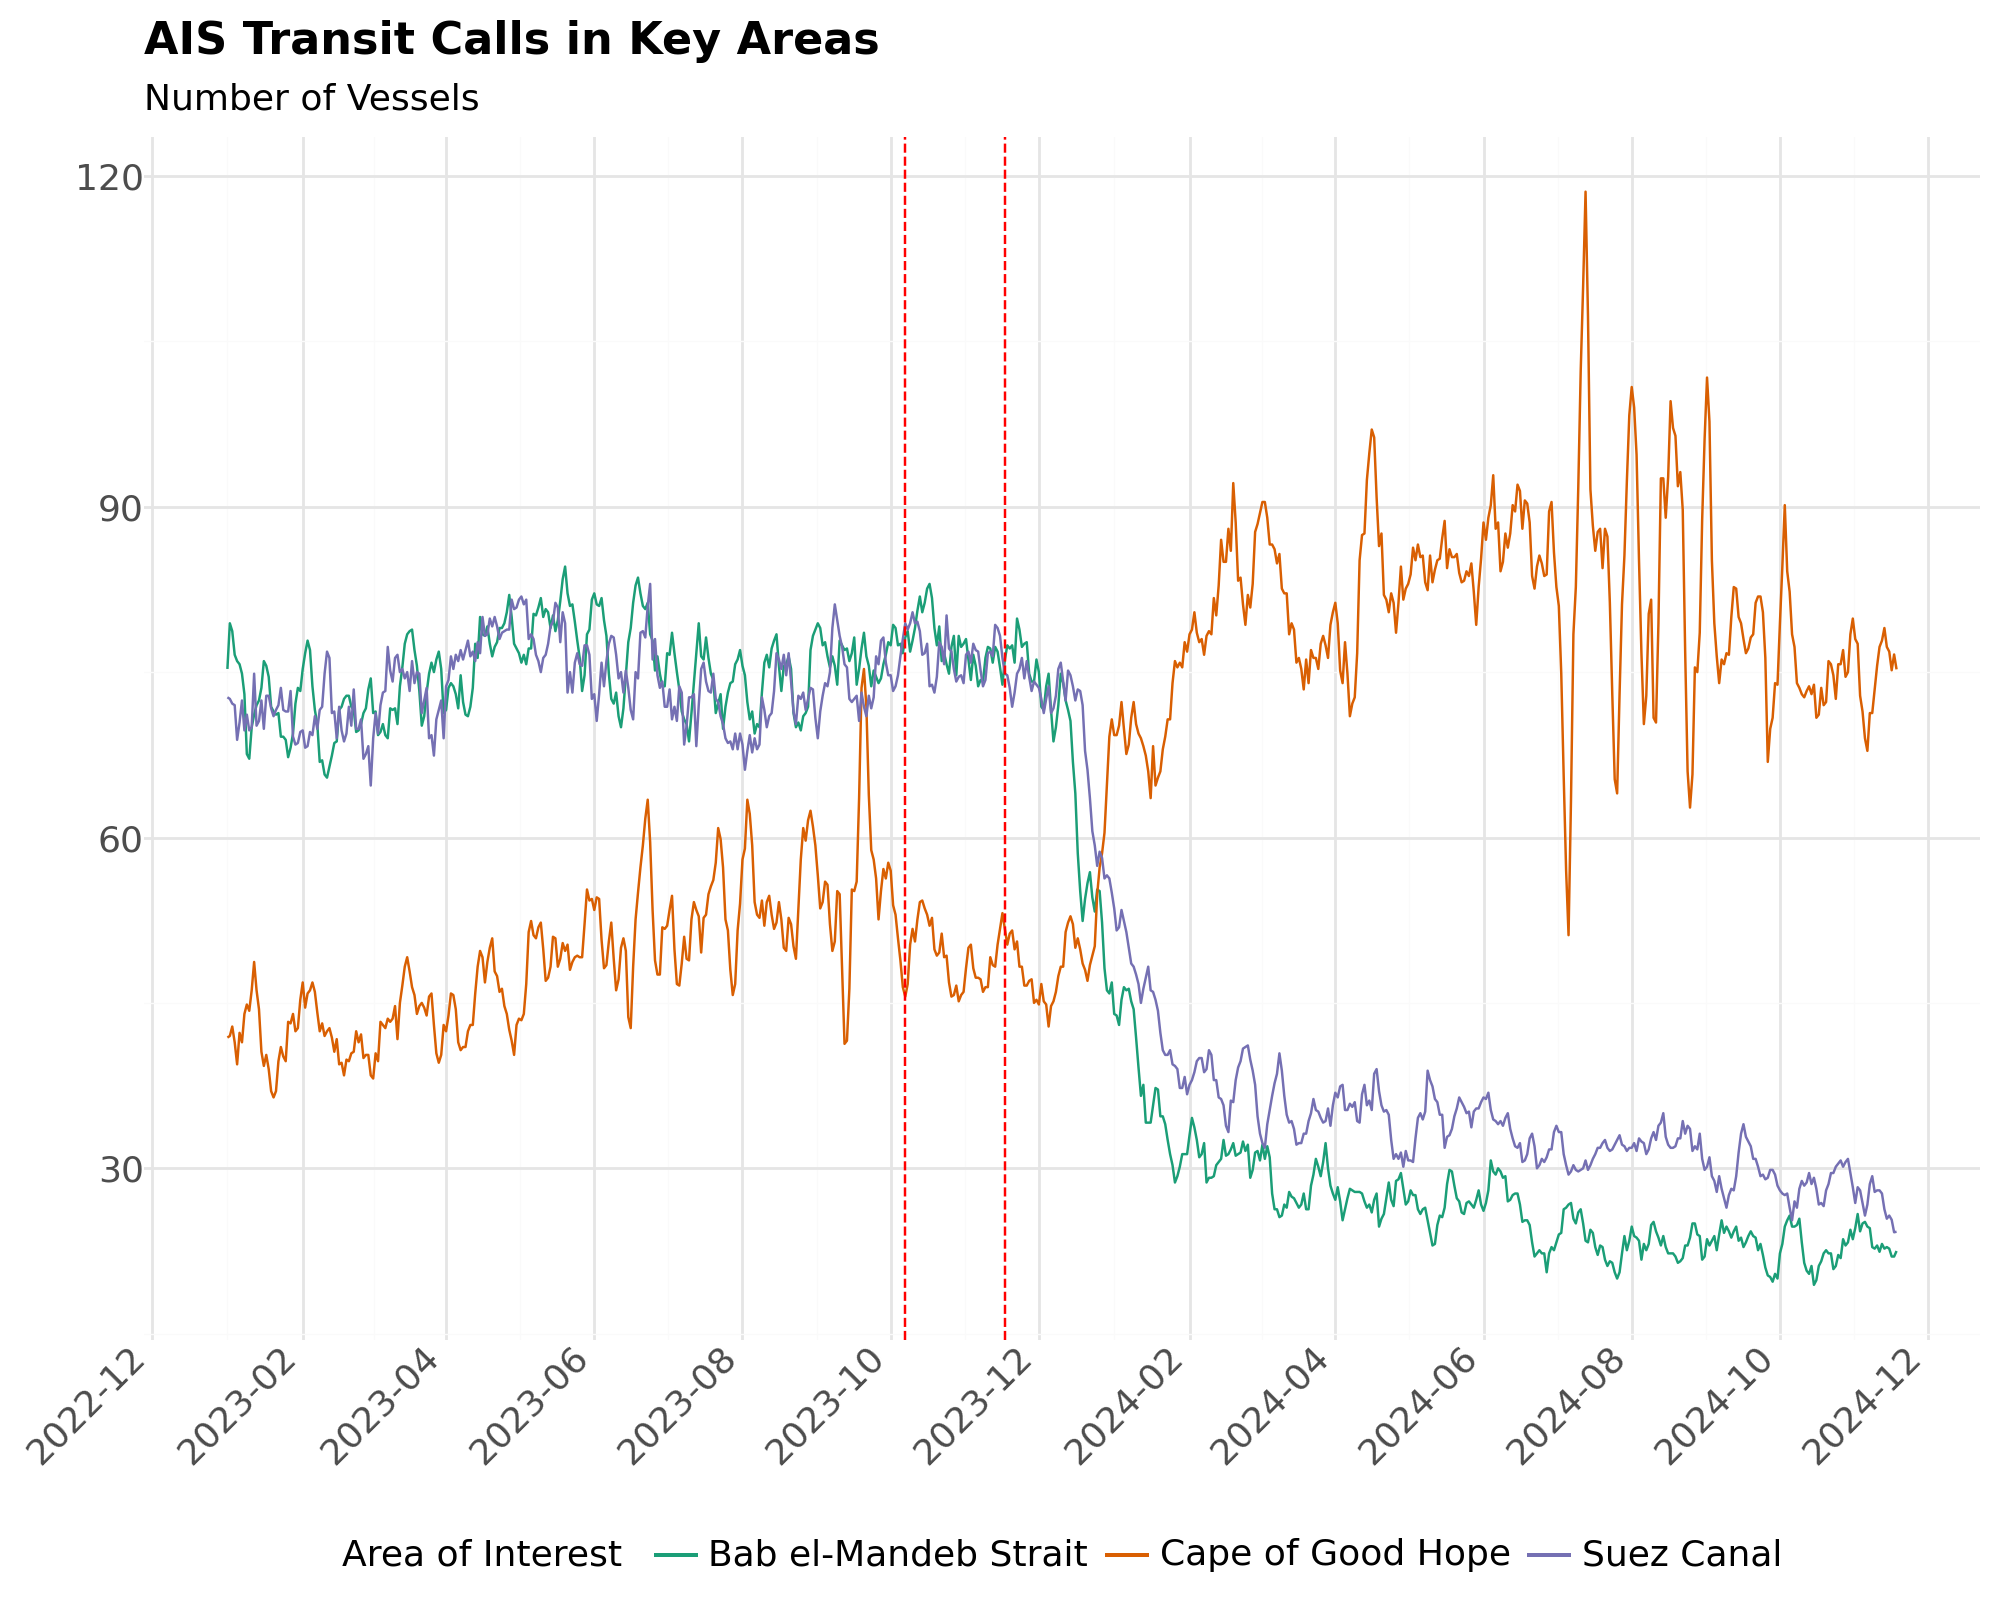

In [22]:
p1 = (
    ggplot(df_filt, aes(x="ymd", y="n_total", group="portname", color="portname"))  #
    + geom_line(alpha=1)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + labs(
        x="",
        y="",
        subtitle="Number of Vessels",
        title="AIS Transit Calls in Key Areas",
        color="Area of Interest",
    )
    + theme_minimal()
    + theme(
        text=element_text(size=13),
        plot_title=element_text(size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
    + scale_x_datetime(breaks=date_breaks("2 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + theme(legend_position="bottom")
)
display(p1)


#### AIS Transit Calls Relative to Historical Average
The following chart separates transit calls for each area and includes a black line, which signals the historical average for each area.

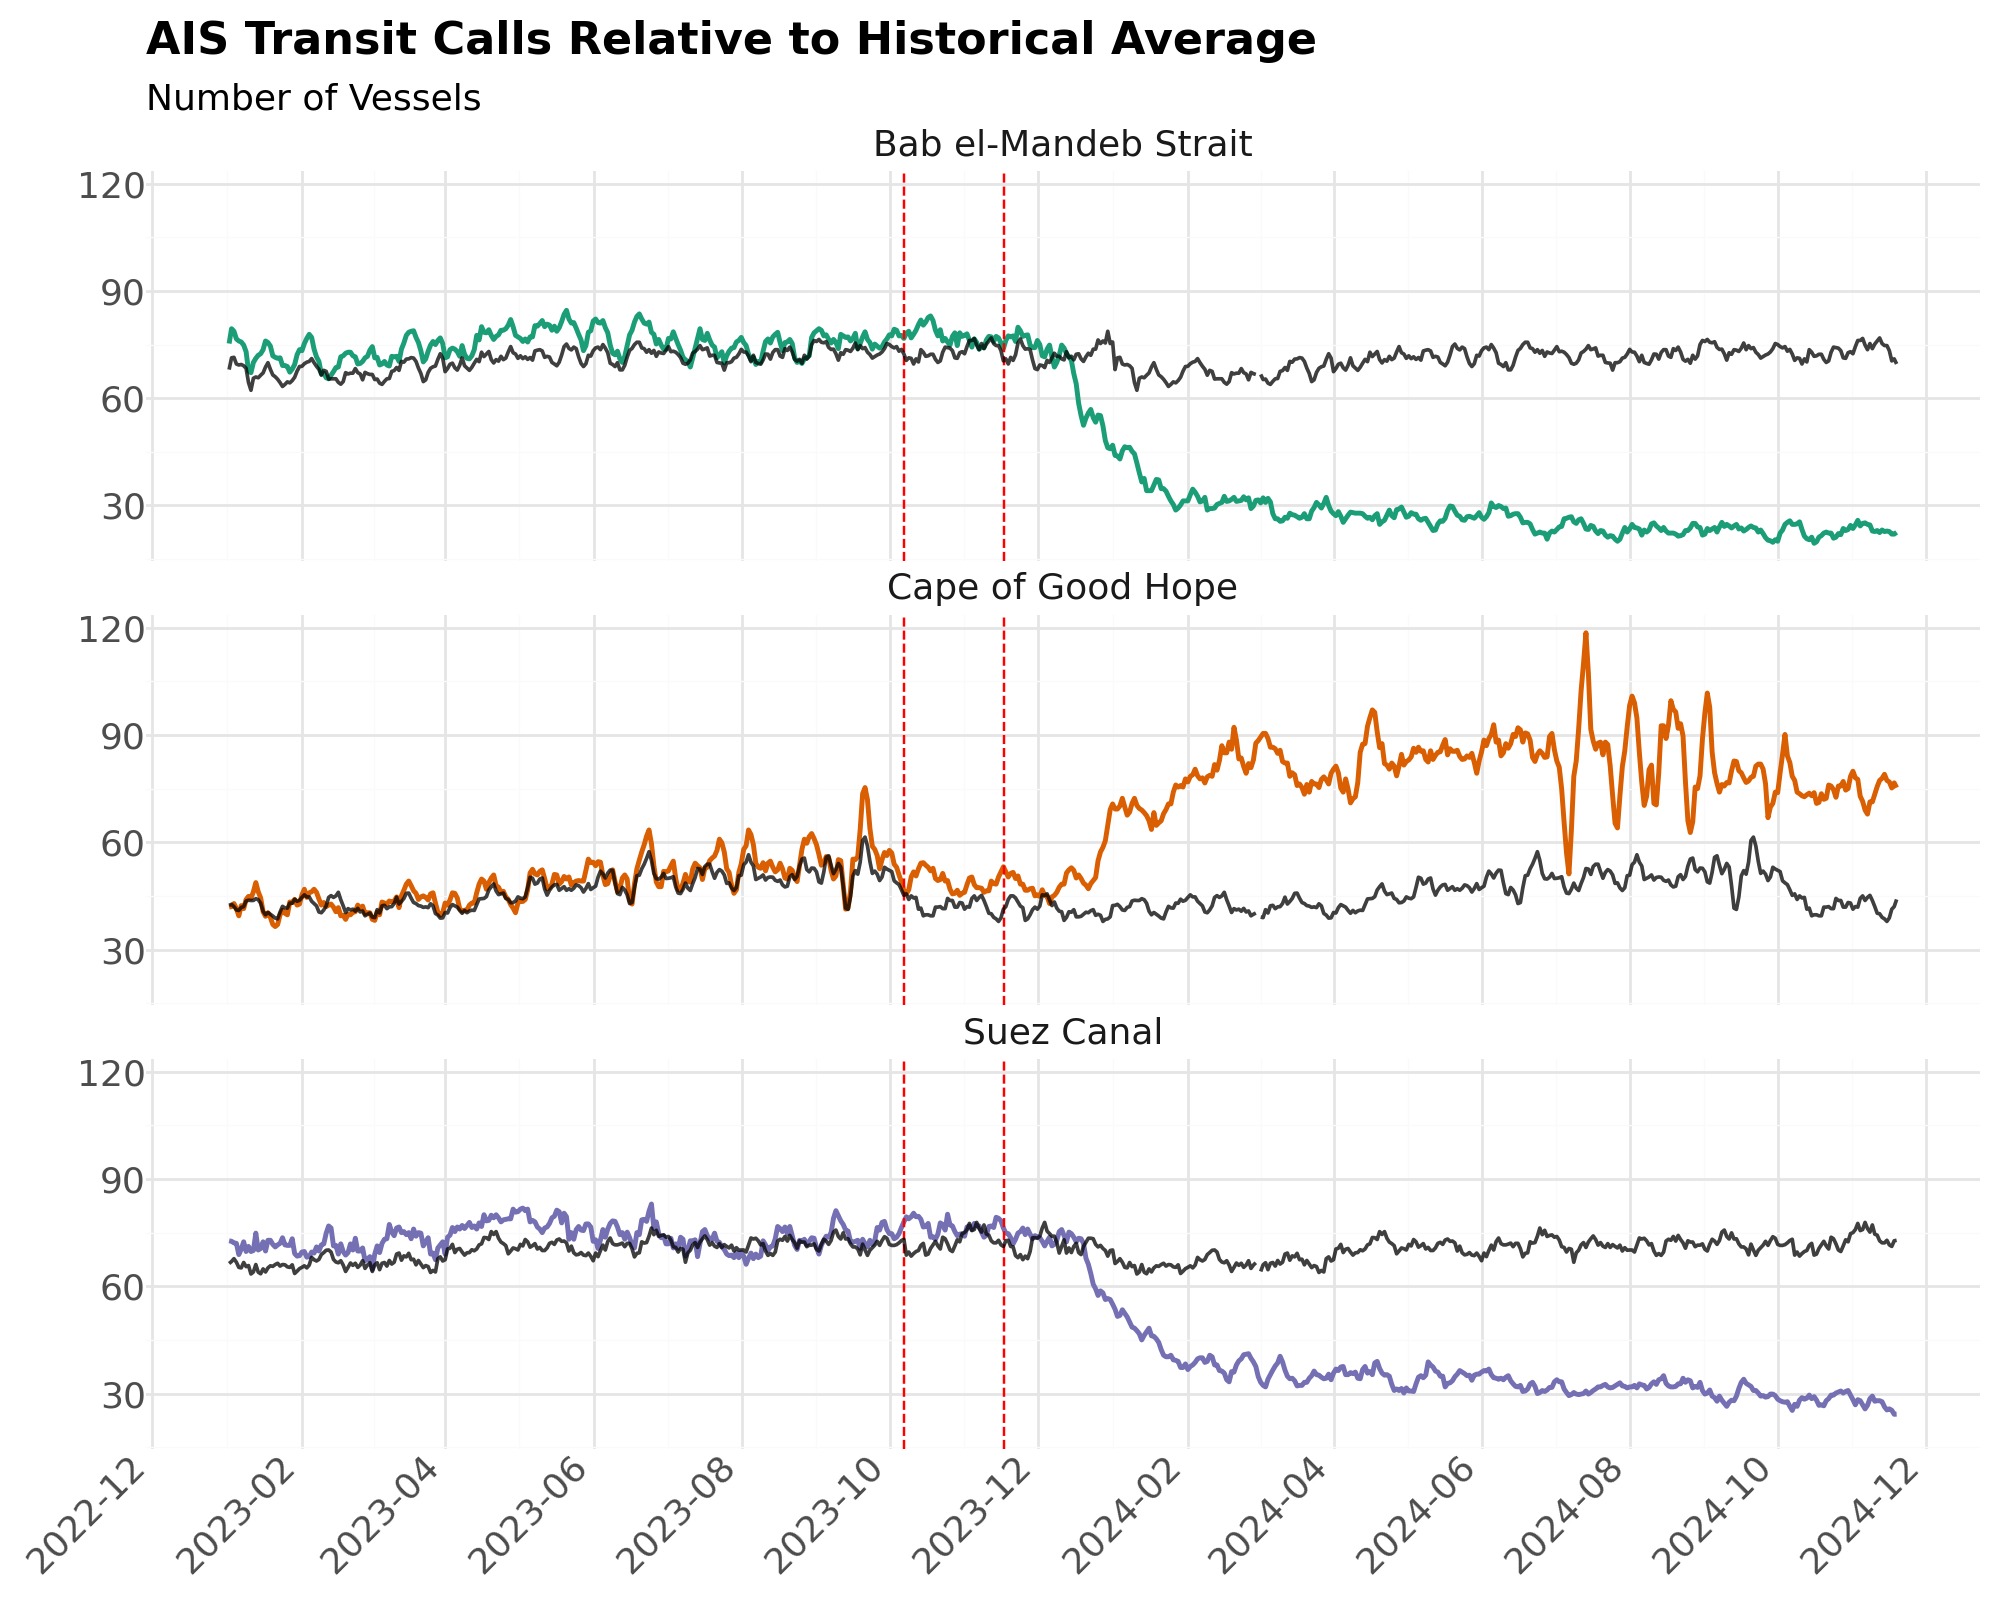

In [23]:
p2 = (
    ggplot(df_filt, aes(x="date", y="n_total", group="portname", color="portname"))  
    + geom_line(size=1)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + geom_line(
        aes(x="date", y="n_total_ref", group="portname"),
        color="black",
        size=0.75,
        alpha=3 / 4,
    )
    + labs(
        x="",
        y="",
        subtitle="Number of Vessels",
        title="AIS Transit Calls Relative to Historical Average",
        color="Area of Interest",
    )
    + theme_minimal()
    + theme(
        text=element_text(size=13),
        plot_title=element_text(size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
    + scale_x_datetime(breaks=date_breaks("2 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + facet_wrap("~portname", scales="fixed", ncol=1)
)
display(p2)

#### AIS Transit Calls % Change from Historical Average
The percentage change between recent daily values and the baseline daily average was calculated.

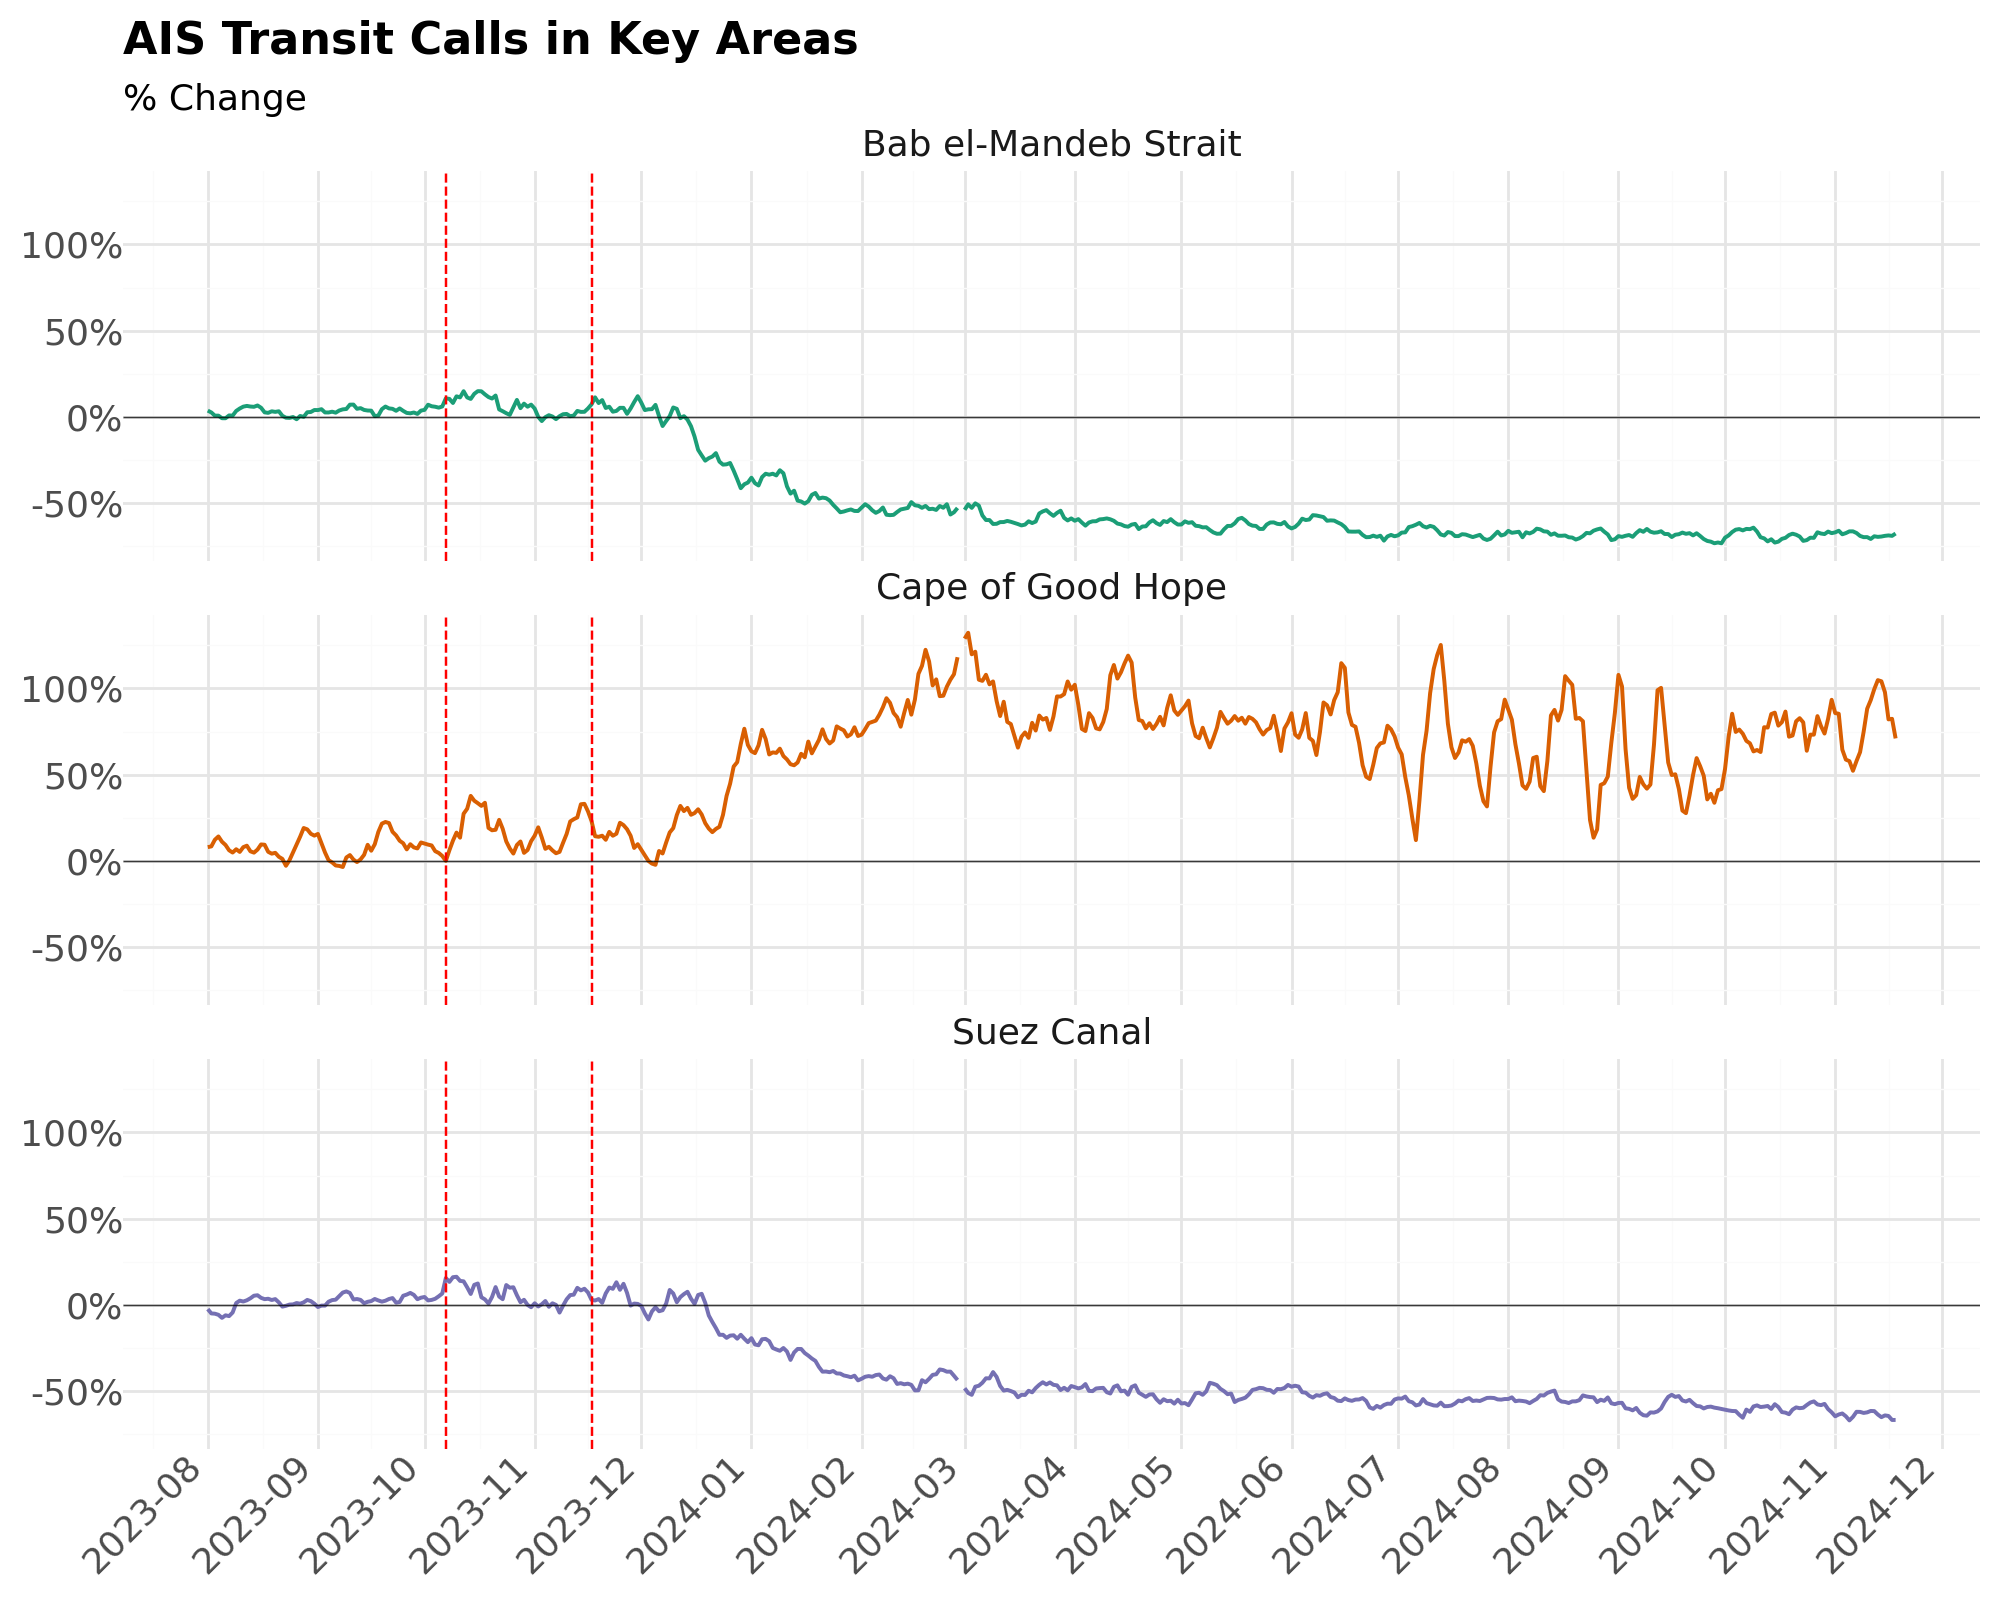

In [24]:
p3 = (
    ggplot(
        df_filt.loc[df_filt.date >= "2023-08-01"],
        aes(x="ymd", y="n_total_pct_ch", group="portname", color="portname"),
    )  #
    + geom_line(size=0.8)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + geom_hline(yintercept=0, color="black", alpha=3 / 4, size=0.3)
    + labs(
        x="",
        y="",
        subtitle="% Change",
        title="AIS Transit Calls in Key Areas",
        color="Area of Interest",
    )
    + theme_minimal()
    + theme(
        text=element_text(size=13),
        plot_title=element_text(size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + scale_y_continuous(labels=percent_format())
    + facet_wrap("~portname", scales="fixed", ncol=1)
)
display(p3)

### Summary Statistics
Finally, aggregate statistics (average values) per area for each period of interest were calculated.

- **Baseline**: January 1st, 2022 – October 6th, 2023
- **Middle East Conflict**: October 7th, 2023 - November 16th, 2023
- **Red Sea Crisis**: November 17th, 2023 - February 19th, 2024

In [25]:
# Define the periods
df_chokepoints.loc[:, "period"] = ""
df_chokepoints.loc[
    (df_chokepoints.date >= start_reference_date) & (df_chokepoints.date < crisis_date), "period"
] = "Reference"
df_chokepoints.loc[
    (df_chokepoints.date >= conflict_date) & (df_chokepoints.date < crisis_date), "period"
] = "Middle East Conflict"
df_chokepoints.loc[(df_chokepoints.date >= crisis_date), "period"] = "Red Sea Crisis"

In [26]:
# Aggregate the data
df_agg = (
    df_chokepoints.loc[df_chokepoints.period != ""]
    .groupby(["portname", "period"])[["n_tanker", "n_cargo", "n_total", "capacity"]]
    .mean()
)

# Change order of rows
df_agg = df_agg.reindex(
    ["Reference", "Middle East Conflict", "Red Sea Crisis"], level=1
)

#### Table: Daily Average Values by Time Period

In [27]:
table = df_agg.copy()
# Format column numbers to 2 decimal places only for first three columns
table.iloc[:, :3] = table.iloc[:, :3].apply(lambda x: round(x, 2))
# Format last column numbers to thousands
table.loc[:, "capacity"] = table.capacity.apply(lambda x: "{:,.0f}".format(x))

table.rename(
    columns={
        "n_tanker": "Tankers",
        "n_cargo": "Cargo",
        "n_total": "Total",
        "capacity": "Capacity",
    },
    inplace=True,
)
table.index.names = ["Area of Interest", "Period"]
display(table)

/tmp/ipykernel_36513/3454507845.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4,386,509' '4,832,362' '1,551,873' '3,848,942' '4,192,709' '6,372,572'
 '4,308,488' '4,773,776' '1,881,587']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


Tankers  Cargo  Total   Capacity
Area of Interest     Period                                                
Bab el-Mandeb Strait Reference               23.96  46.91  70.87  4,386,509
                     Middle East Conflict    25.95  51.54  77.49  4,832,362
                     Red Sea Crisis          10.67  20.94  31.62  1,551,873
Cape of Good Hope    Reference                9.35  36.69  46.04  3,848,942
                     Middle East Conflict    10.03  39.13  49.15  4,192,709
                     Red Sea Crisis          16.85  60.11  76.95  6,372,572
Suez Canal           Reference               23.13  46.98  70.12  4,308,488
                     Middle East Conflict    25.20  51.54  76.74  4,773,776
                     Red Sea Crisis          12.84  25.43  38.27  1,881,587

#### Table: Daily Average Values by Time Period, % Change from Baseline

In [28]:
df_agg_copy = df_agg.copy()

In [29]:
res = []
for aoi in cpoi:
    df_sub = df_agg_copy.loc[(aoi), :].transpose().copy()
    df_sub.loc[:, "Middle East Conflict"] = (
        df_sub.loc[:, "Middle East Conflict"] - df_sub.loc[:, "Reference"]
    ) / df_sub.loc[:, "Reference"]
    df_sub.loc[:, "Red Sea Crisis"] = (
        df_sub.loc[:, "Red Sea Crisis"] - df_sub.loc[:, "Reference"]
    ) / df_sub.loc[:, "Reference"]
    df_sub2 = df_sub.transpose()
    df_sub2.drop("Reference", inplace=True)
    df_sub2.loc[:, "portname"] = aoi
    res.append(df_sub2)
df_agg_pct = pd.concat(res)

In [30]:
df_agg_pct.reset_index(inplace=True)
df_agg_pct.set_index(["portname", "period"], inplace=True)

# Format columns as pct
df_agg_pct = df_agg_pct.applymap(lambda x: "{:.2%}".format(x))
df_agg_pct.rename(
    columns={
        "n_tanker": "Tankers",
        "n_cargo": "Cargo",
        "n_total": "Total",
        "capacity": "Capacity",
    },
    inplace=True,
)
df_agg_pct.index.names = ["Area of Interest", "Period"]
display(df_agg_pct)

/tmp/ipykernel_36513/3184510119.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Tankers    Cargo    Total Capacity
Area of Interest     Period                                                  
Bab el-Mandeb Strait Middle East Conflict    8.29%    9.86%    9.33%   10.16%
                     Red Sea Crisis        -55.46%  -55.36%  -55.39%  -64.62%
Cape of Good Hope    Middle East Conflict    7.22%    6.65%    6.77%    8.93%
                     Red Sea Crisis         80.14%   63.84%   67.15%   65.57%
Suez Canal           Middle East Conflict    8.92%    9.70%    9.45%   10.80%
                     Red Sea Crisis        -44.50%  -45.87%  -45.42%  -56.33%